<h1 style="color:magenta">
Pneumonia Image EDA + Classification
</h1> 

![Credits: Harvard Health](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.health.harvard.edu%2Fmedia%2Fcontent%2Fimages%2Fmedical-illustrations%2Fpneumonia-GettyImages-1010467510.jpg&f=1&nofb=1)

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable.

Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), sickle cell disease, asthma, diabetes, heart failure, a history of smoking, a poor ability to cough (such as following a stroke), and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia. 

<strong><span style="color:red">If you like my work, please don't forget to upvote this notebook!</span></strong>

<strong><span style="color:blue"> If you don't, atleast leave a comment on what should I do to improve it!</span></strong>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob

import albumentations as A

from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=3, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

In [3]:
# Look at the training, testing and validation data numbers
train_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg')
test_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/test/**/*.jpeg')
val_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg')

print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")

Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images


## Target Value Distribution
Before we start Image EDA, let's take a look at Target Value Distribution for all sets.

In [4]:
DIR = "../input/chest-xray-pneumonia/chest_xray/"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 4273
Total Normal Images: 1583


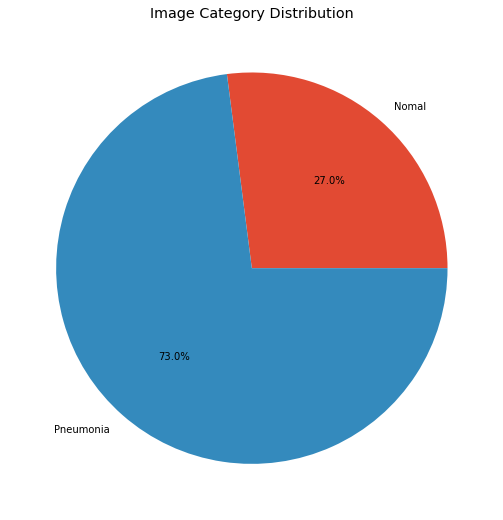

In [5]:
labels = ['Nomal', 'Pneumonia']
targets = [len(all_normal), len(all_pneumonia)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

We can see that there's some good data imbalance, we have more data for Pneumonia Images then for the Normal Images. If we were to leave this problem alone, it would decrease model performance.

# EDA
Let's start the Image EDA!

In [6]:
# Shuffle and Get some images into new list
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]

## Basic XRay Images
Let's first view just the x-ray images, nothing fancy.

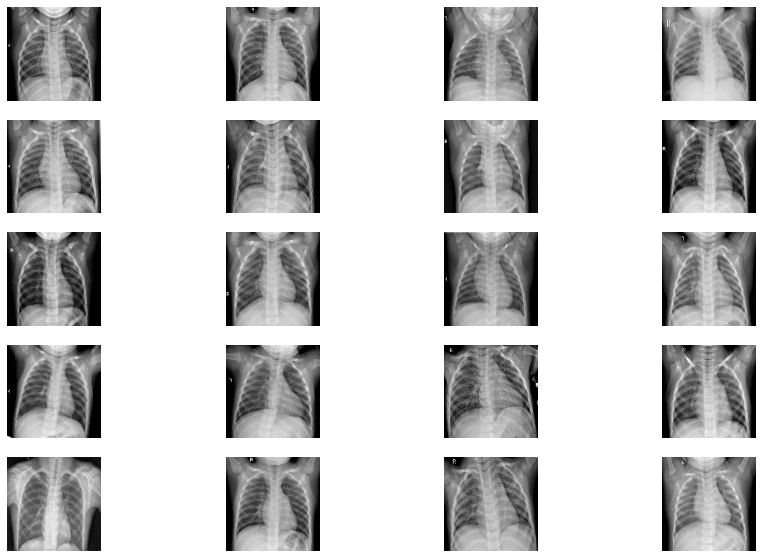

In [7]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 5
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

## Ben Graham's Method
Let's try using Ben Graham's method. It involves using grayscale images and then applying Gaussian Blur to them later.

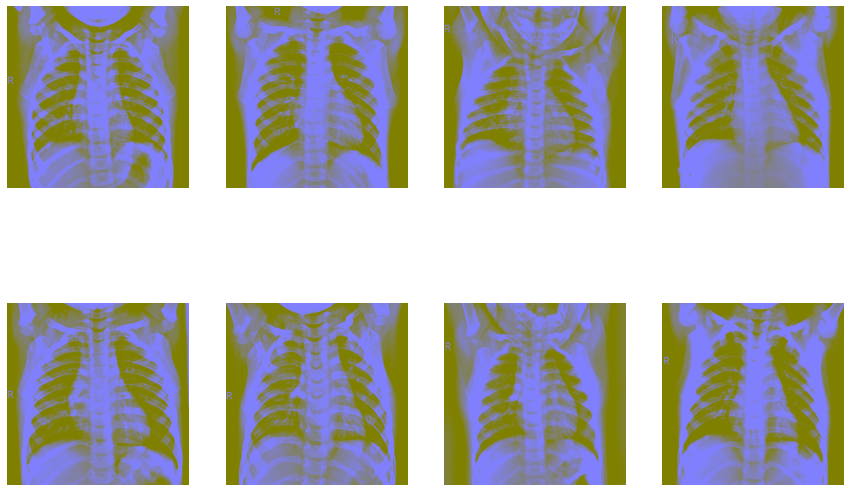

In [8]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

## Background Subtraction
Now we will use Background Subtraction Method using Built-in OpenCV function.

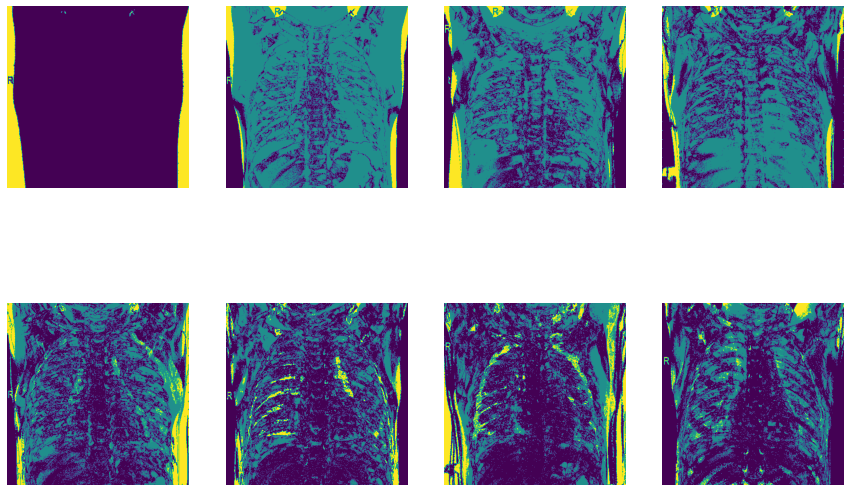

In [9]:
fgbg = cv2.createBackgroundSubtractorMOG2()

fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = fgbg.apply(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

Ok, that didn't work as I expected.

## Fourier Method for Pixel Distribution
Let's use Fourier Transforms

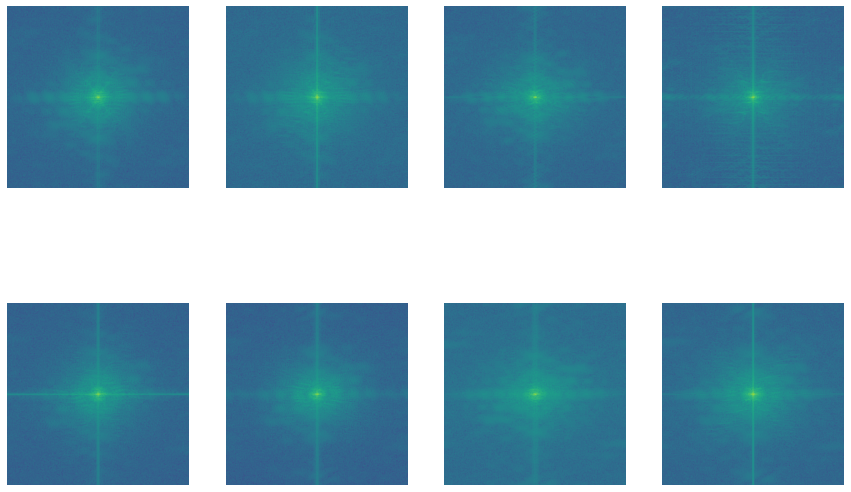

In [10]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

You might think that it's just a bunch of blue dots, but it's more than that.

**Whats happening here is that those images are basically magnitude spectrums, this helps in understanding where majority of growth is situated.**

## Albumentations Visualization
Let's visualize how our images will be looking after some Albumentations.

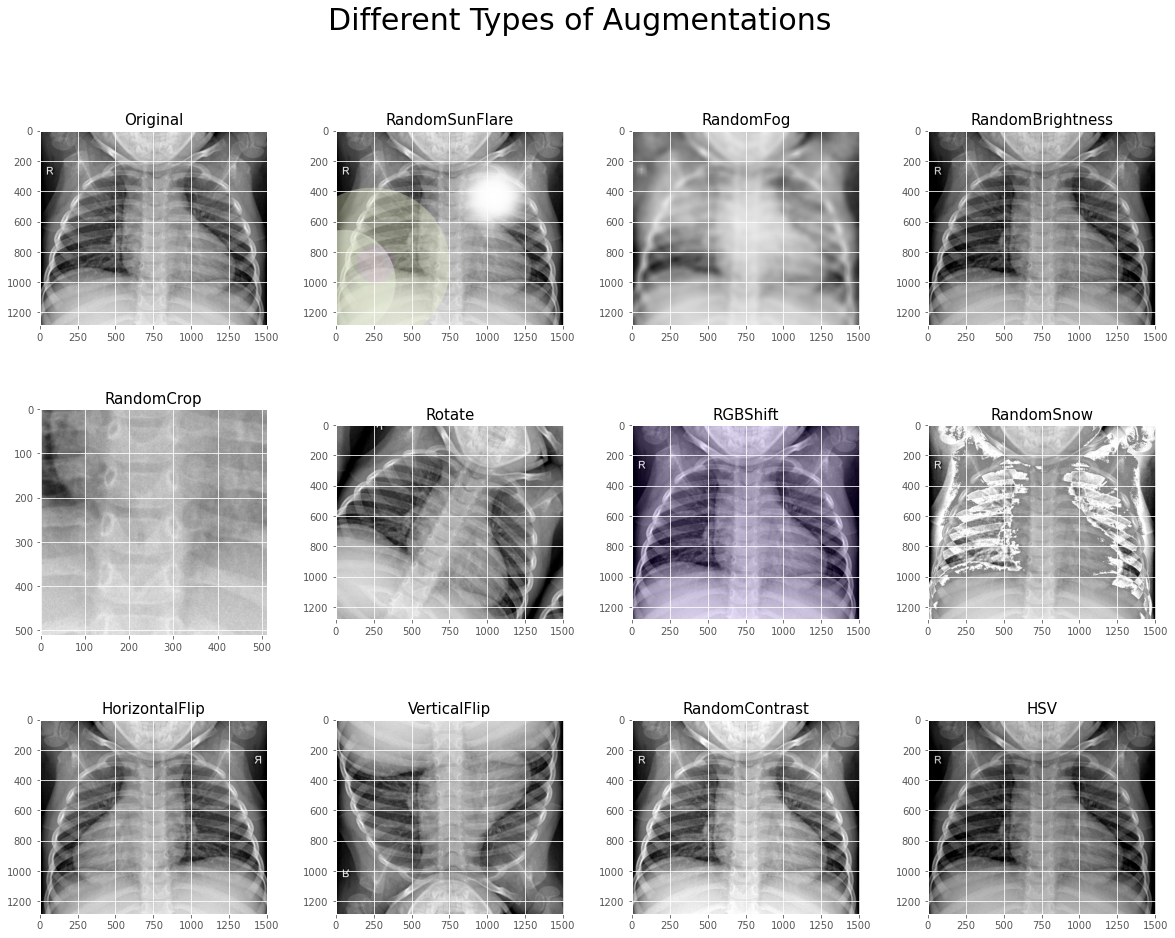

In [11]:
chosen_image = cv2.imread(images[25])
albumentation_list = [A.RandomSunFlare(p=1), A.RandomFog(p=1), A.RandomBrightness(p=1),
                      A.RandomCrop(p=1,height = 512, width = 512), A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1), A.RandomSnow(p=1),
                      A.HorizontalFlip(p=1), A.VerticalFlip(p=1), A.RandomContrast(limit = 0.5,p = 1),
                      A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original","RandomSunFlare","RandomFog","RandomBrightness",
               "RandomCrop","Rotate", "RGBShift", "RandomSnow","HorizontalFlip", "VerticalFlip", "RandomContrast","HSV"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4,main_title="Different Types of Augmentations")

## Image Erosion

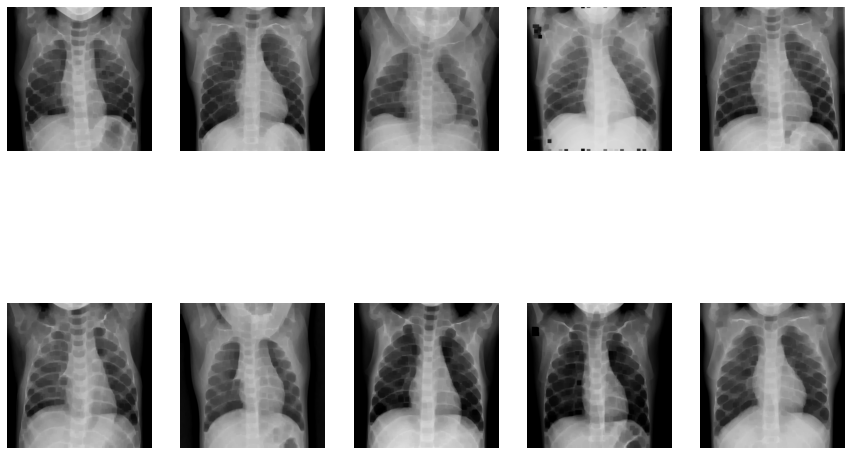

In [12]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

## Image Dilation

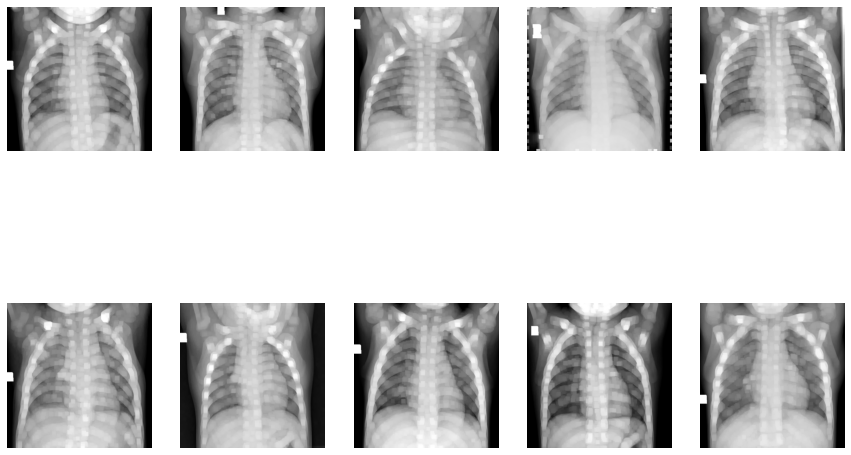

In [13]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

## Canny Edge Detection
Finally, let's do Canny Edge Detection on our data so we can get some usefull insights from it!

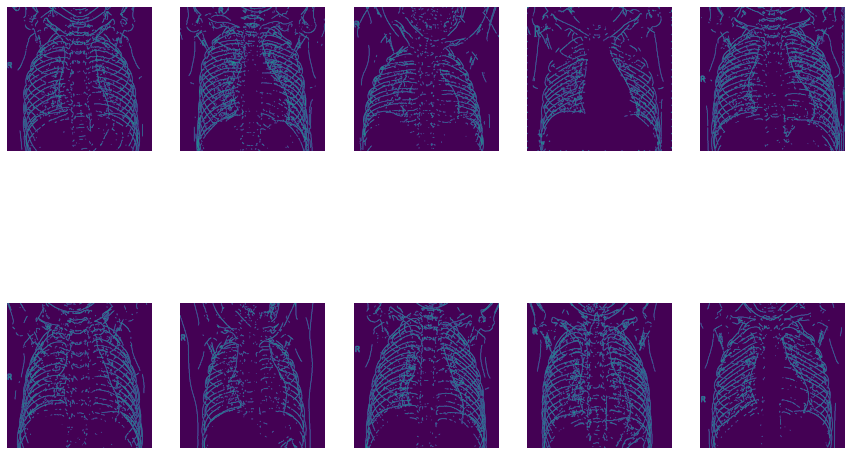

In [14]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

# Modelling
Now that the EDA is over, let's start with the process of modelling.
We will divide this into 4 parts:

1. Dataset (using DataGenerator)
2. Model
3. Training
4. Model Performance viz.

## 1. Dataset
Let's define our data using the Keras Image DataGenerator.
It helps us by directly reading the images from their directories

In [15]:
# Define Training and Validation Data Generator with Augmentations
train_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.4,
    zoom_range=0.4
)
val_gen = ImageDataGenerator(
    rescale=1/255.,
)

In [16]:
# Flow the data into the Data Generator
Train = train_gen.flow_from_directory(
    "../input/chest-xray-pneumonia/chest_xray/train",
    target_size=(224, 224),
    batch_size=16
)
Test = train_gen.flow_from_directory(
    "../input/chest-xray-pneumonia/chest_xray/test",
    target_size=(224, 224),
    batch_size=8
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 2. Model
Now, let's design a simple CNN using Keras Sequenatial API

In [17]:
model = Sequential()
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [18]:
# Compile the model and see it's structure and parameters
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        1

## 3. Training
Now, let's quickly train our model for `10 Epochs` and see how performs.

In [19]:
hist = model.fit_generator(
    Train,
    epochs=20,
    validation_data=Test
)

Epoch 1/20
326/326 [==============================] - 138s 422ms/step - loss: 0.4526 - accuracy: 0.7951 - val_loss: 0.4952 - val_accuracy: 0.7548
Epoch 2/20
326/326 [==============================] - 121s 371ms/step - loss: 0.3227 - accuracy: 0.8587 - val_loss: 0.4277 - val_accuracy: 0.7981
Epoch 3/20
326/326 [==============================] - 119s 366ms/step - loss: 0.2818 - accuracy: 0.8796 - val_loss: 0.5045 - val_accuracy: 0.7869
Epoch 4/20
326/326 [==============================] - 117s 358ms/step - loss: 0.2581 - accuracy: 0.8901 - val_loss: 0.3664 - val_accuracy: 0.8429
Epoch 5/20
326/326 [==============================] - 116s 356ms/step - loss: 0.2413 - accuracy: 0.8972 - val_loss: 0.5046 - val_accuracy: 0.7885
Epoch 6/20
326/326 [==============================] - 115s 353ms/step - loss: 0.2278 - accuracy: 0.9041 - val_loss: 0.3578 - val_accuracy: 0.8606
Epoch 7/20
326/326 [==============================] - 116s 356ms/step - loss: 0.2132 - accuracy: 0.9116 - val_loss: 0.3964 -

In [20]:
# Save the model
model.save("best_model.hdf5")

## 4. Performance Viz.
Let's visualize our model's performance

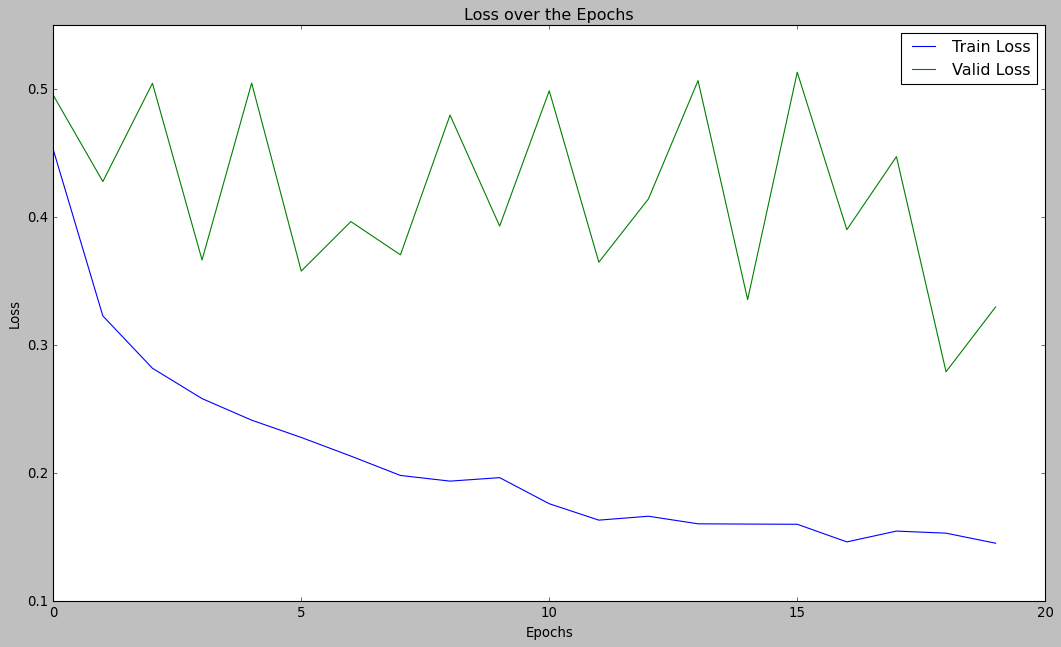

In [21]:
plt.style.use("classic")
plt.figure(figsize=(16, 9))
plt.plot(hist.history['loss'], label="Train Loss")
plt.plot(hist.history['val_loss'], label="Valid Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over the Epochs")
plt.show()

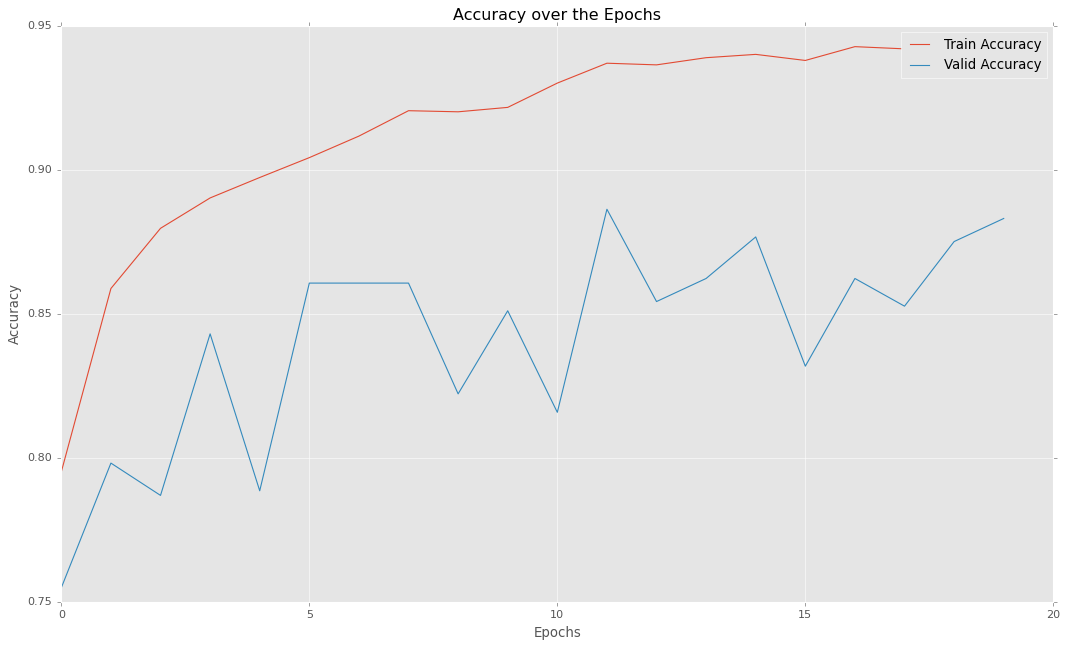

In [22]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.plot(hist.history['accuracy'], label="Train Accuracy")
plt.plot(hist.history['val_accuracy'], label="Valid Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over the Epochs")
plt.show()